# Embedding Model

In [1]:
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D  # For custom legend markers
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Layer, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import warnings # ignore warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/final_df_normalized.csv', sep='|') 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   account_id                              100000 non-null  object 
 1   yeojohnson_revenue_in_eur_bin           100000 non-null  float64
 2   is_EMEA                                 100000 non-null  int64  
 3   is_Webshop                              100000 non-null  int64  
 4   is_industry_FinanceInsuranceRealEstate  100000 non-null  int64  
 5   is_industry_Manufacturing               100000 non-null  int64  
 6   is_industry_Other                       100000 non-null  int64  
 7   is_industry_RetailTrade                 100000 non-null  int64  
 8   is_industry_Services                    100000 non-null  int64  
 9   is_industry_WholesaleTrade              100000 non-null  int64  
 10  license_value_score                     10000

In [4]:
df.head(10)

,account_id,yeojohnson_revenue_in_eur_bin,is_EMEA,is_Webshop,is_industry_FinanceInsuranceRealEstate,is_industry_Manufacturing,is_industry_Other,is_industry_RetailTrade,is_industry_Services,is_industry_WholesaleTrade,license_value_score,customer_value_score
0,ac6a99474410f1c59c91da3f0cf9cf3f,0.666667,0,1,0,0,0,0,1,0,0.225903,0.404288
1,1cc66628ed41f3db5a55195e93277a04,0.666667,0,1,0,0,0,0,0,1,0.692198,0.000000
2,db5f3cdd5629b9591b720b9b7e077df2,1.000000,0,1,0,0,0,0,1,0,0.025903,0.058008
3,bebb4028688f519f36ed220855b0a62f,1.000000,0,0,0,0,0,0,1,0,0.825945,0.703012
4,507c0bfb67895d773e3f8bd33b861d09,1.000000,0,0,1,0,0,0,0,0,0.826668,0.467596
5,b1267a5b953b7267de811510f838172b,0.666667,0,1,0,0,0,1,0,0,0.172568,0.270317
6,3315ad169d4d2e9080f1377c44377c7c,0.666667,0,0,0,0,0,0,1,0,0.784642,0.863665
7,8ca7b69eda1a06b32e60fff1c6db3b28,1.000000,0,0,0,0,1,0,0,0,0.530824,0.608520
8,5bd2eea4e2320b9246b41a8f54fb02d2,0.333333,0,0,0,0,0,0,1,0,0.925757,0.625388
9,bbfb03bca60fb0185be3f36d12c99b3f,0.666667,0,0,0,0,0,0,1,0,0.864130,0.635761


## Deep Embedding Clustering (DEC) Model

In [5]:
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, **kwargs):
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters

    def build(self, input_shape):
        self.clusters = self.add_weight(name='clusters',
                                        shape=(self.n_clusters, input_shape[1]),
                                        initializer='glorot_uniform')

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / 1.0))
        q = q ** ((1.0 + 1.0) / 2.0)
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

class DEC:
    def __init__(self, input_dim, encoding_dim, n_clusters, dropout_rate=0.2):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.n_clusters = n_clusters
        self.dropout_rate = dropout_rate
        self.autoencoder, self.encoder = self.build_autoencoder()
        self.model = self.build_dec_model()

    def build_autoencoder(self):
        input_layer = Input(shape=(self.input_dim,))
        encoder = Dense(64, activation='relu')(input_layer)
        encoder = Dropout(self.dropout_rate)(encoder)
        encoder = Dense(self.encoding_dim, activation='relu', kernel_initializer='glorot_uniform')(encoder)

        decoder = Dense(64, activation='relu', kernel_initializer='glorot_uniform')(encoder)
        decoder = Dropout(self.dropout_rate)(decoder)
        decoder = Dense(self.input_dim, activation='sigmoid', kernel_initializer='glorot_uniform')(decoder)

        autoencoder = Model(inputs=input_layer, outputs=decoder)
        autoencoder.compile(optimizer='adam', loss='mse')

        encoder_model = Model(inputs=input_layer, outputs=encoder)
        return autoencoder, encoder_model

    def build_dec_model(self):
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.encoder.output)
        model = Model(inputs=self.encoder.input, outputs=[clustering_layer, self.autoencoder.output])
        model.compile(optimizer='adam', loss=['kld', 'mse'])
        return model

    def pretrain_autoencoder(self, data, epochs=50, batch_size=256):
        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
            self.autoencoder.fit(data, data, epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[early_stopping])

    def initialize_clusters(self, data):
        with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
            encoded_data = self.encoder.predict(data)
            kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
            kmeans.fit(encoded_data)
            initial_clusters = kmeans.cluster_centers_
            self.model.get_layer(name='clustering').set_weights([initial_clusters])

    def target_distribution(self, q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def train_dec(self, data, maxiter=8000, update_interval=140, tol=0.001):
        index = 0
        y_pred_last = None
        with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
            for ite in range(maxiter):
                if ite % update_interval == 0:
                    q, _ = self.model.predict(data, verbose=0)
                    p = self.target_distribution(q)

                    y_pred = q.argmax(1)
                    if ite > 0 and np.sum(y_pred != y_pred_last) / len(y_pred) < tol:
                        print('Reached tolerance threshold. Stopping training.')
                        break
                    y_pred_last = np.copy(y_pred)

                idx = index * update_interval % data.shape[0]
                loss = self.model.train_on_batch(x=data[idx:idx + update_interval],
                                                 y=[p[idx:idx + update_interval], data[idx:idx + update_interval]])
                index += 1
                print('Iteration', ite, 'Loss:', loss)

    def predict(self, data):
        with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
            q, _ = self.model.predict(data)
            return q.argmax(1)

In [6]:
# Preprocess the data

# Extract features columns excluding 'account_id'
features_df = df.drop(columns=['account_id'])

# Convert DataFrame to numpy array
features = features_df.to_numpy()

# Selecting the last 2 Features
scores_df = features_df.iloc[:, -2:]

# Convert DataFrame to numpy array
score_features = scores_df.to_numpy()

In [7]:
scores_df

,license_value_score,customer_value_score
0,0.225903,0.404288
1,0.692198,0.000000
2,0.025903,0.058008
3,0.825945,0.703012
4,0.826668,0.467596
...,...,...
99995,0.475269,0.683419
99996,0.562420,0.861997
99997,0.225903,0.243447
99998,0.073531,0.058008


In [8]:
score_features.shape

(100000, 2)

In [9]:
# Parameters
input_dim = score_features.shape[1]
encoding_dim = 2
n_clusters = 10
dropout_rate = 0.2

In [10]:
# Create DEC instance
dec = DEC(input_dim, encoding_dim, n_clusters, dropout_rate)

In [11]:
# Pretrain autoencoder
dec.pretrain_autoencoder(score_features, epochs=50, batch_size=256)

Epoch 1/50
391/391 [==============================] - 2s 2ms/step - loss: 0.0242
Epoch 2/50
391/391 [==============================] - 1s 2ms/step - loss: 0.0040
Epoch 3/50
391/391 [==============================] - 1s 2ms/step - loss: 0.0029
Epoch 4/50
391/391 [==============================] - 1s 2ms/step - loss: 0.0023
Epoch 5/50
391/391 [==============================] - 1s 2ms/step - loss: 0.0018
Epoch 6/50
391/391 [==============================] - 1s 2ms/step - loss: 0.0016
Epoch 7/50
391/391 [==============================] - 1s 2ms/step - loss: 0.0015
Epoch 8/50
391/391 [==============================] - 1s 2ms/step - loss: 0.0014
Epoch 9/50
391/391 [==============================] - 1s 2ms/step - loss: 0.0014
Epoch 10/50
391/391 [==============================] - 1s 2ms/step - loss: 0.0013
Epoch 11/50
391/391 [==============================] - 1s 2ms/step - loss: 0.0013
Epoch 12/50
391/391 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 13/50
391/391 [====

In [12]:
# Initialize clusters
dec.initialize_clusters(score_features)

3125/3125 [==============================] - 2s 538us/step


In [13]:
# Train DEC model
dec.train_dec(score_features, maxiter=8000, update_interval=140, tol=0.001)

Iteration 0 Loss: [0.054749324917793274, 0.05362887680530548, 0.001120448694564402]
Iteration 1 Loss: [0.04998604953289032, 0.048853497952222824, 0.0011325506493449211]
Iteration 2 Loss: [0.04590817913413048, 0.044899340718984604, 0.0010088381823152304]
Iteration 3 Loss: [0.04330233111977577, 0.04208488389849663, 0.0012174485018476844]
Iteration 4 Loss: [0.046667810529470444, 0.04536573961377144, 0.0013020695187151432]
Iteration 5 Loss: [0.05183795094490051, 0.05034850165247917, 0.0014894490595906973]
Iteration 6 Loss: [0.038721051067113876, 0.037355732172727585, 0.001365317264571786]
Iteration 7 Loss: [0.041513483971357346, 0.04007957875728607, 0.0014339061453938484]
Iteration 8 Loss: [0.04368768259882927, 0.041867636144161224, 0.0018200450576841831]
Iteration 9 Loss: [0.04658706858754158, 0.04484161362051964, 0.0017454538028687239]
Iteration 10 Loss: [0.04318680241703987, 0.041602980345487595, 0.001583821140229702]
Iteration 11 Loss: [0.04680706188082695, 0.045274678617715836, 0.0015

In [14]:
# Predict clusters
clusters = dec.predict(score_features)
print("Predicted clusters:", clusters)

3125/3125 [==============================] - 3s 899us/step
Predicted clusters: [2 3 2 ... 2 2 4]


In [15]:
encoded_data = dec.encoder.predict(score_features)

3125/3125 [==============================] - 2s 558us/step


## Determine the number of clusters(k)

In [16]:
# Define a range of k values to test
k_range = range(1, 20)

wcss = []
for k in k_range:
    print('Now on k {}'.format(k))
    kmeans = KMeans(n_clusters=k, random_state=0).fit(encoded_data)
    wcss.append(kmeans.inertia_)

Now on k 1
Now on k 2
Now on k 3
Now on k 4
Now on k 5
Now on k 6
Now on k 7
Now on k 8
Now on k 9
Now on k 10
Now on k 11
Now on k 12
Now on k 13
Now on k 14
Now on k 15
Now on k 16
Now on k 17
Now on k 18
Now on k 19


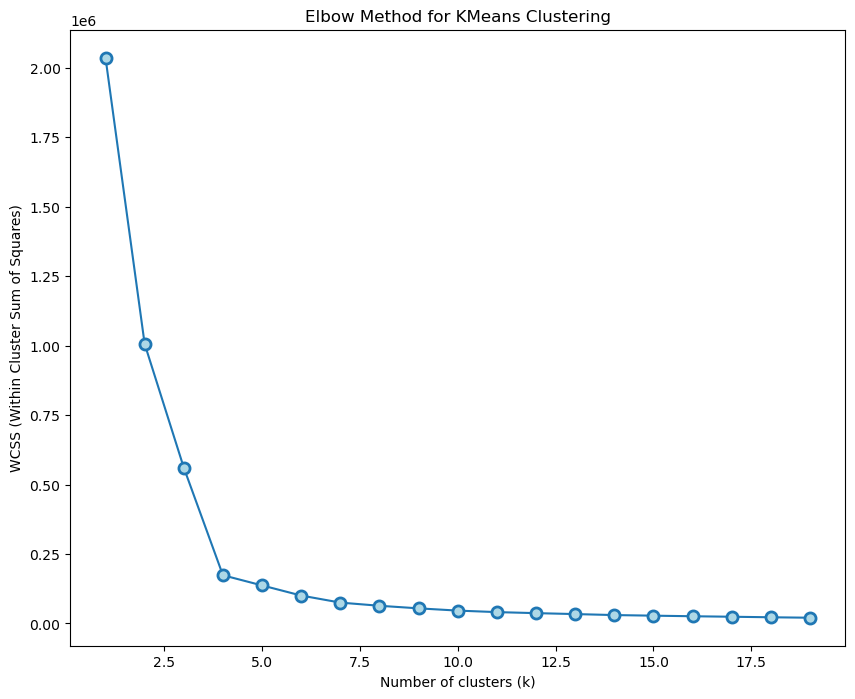

In [17]:
# Plotting WCSS vs k to identify the elbow point
plt.figure(figsize=(10, 8))
plt.plot(k_range, wcss, 'o-', markerfacecolor='lightblue', markeredgewidth=2, markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.title('Elbow Method for KMeans Clustering')
plt.show()

## Clustering

In [18]:
# Fit the KMeans model
kmeans = KMeans(n_clusters=4, random_state=0).fit(encoded_data)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

df['cluster_kmeans'] = kmeans.predict(encoded_data)
df.groupby(['cluster_kmeans']).mean()

,yeojohnson_revenue_in_eur_bin,is_EMEA,is_Webshop,is_industry_FinanceInsuranceRealEstate,is_industry_Manufacturing,is_industry_Other,is_industry_RetailTrade,is_industry_Services,is_industry_WholesaleTrade,license_value_score,customer_value_score
cluster_kmeans,,,,,,,,,,,
0,0.615526,0.799227,0.220001,0.078485,0.151714,0.139314,0.077901,0.434521,0.118065,0.802454,0.715006
1,0.421921,0.732738,0.738674,0.073573,0.123429,0.167147,0.116916,0.430144,0.088790,0.178794,0.204362
2,0.452212,0.818524,0.464879,0.063317,0.134999,0.131454,0.089242,0.475460,0.105528,0.422589,0.697065
3,0.540038,0.707151,0.401697,0.084997,0.138821,0.166033,0.094922,0.422066,0.093161,0.533419,0.193217


In [19]:
# df.mean()

In [20]:
df.cluster_kmeans.value_counts()

1    34700
3    24989
0    22259
2    18052
Name: cluster_kmeans, dtype: int64

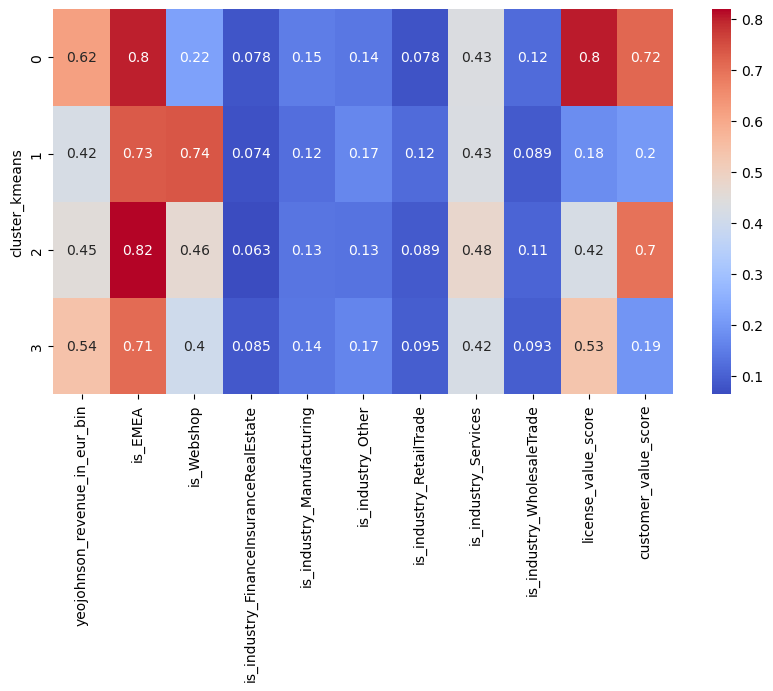

In [21]:
# Visualize the correlation matrix
plt.figure(figsize=(10,5))
sns.heatmap(df.groupby(['cluster_kmeans']).mean(), cmap='coolwarm', annot=True)
plt.show()

In [22]:
clusters=pd.DataFrame(features, columns=features_df.columns)
clusters['label']=kmeans.labels_
polar=clusters.groupby("label").mean().reset_index()
polar=pd.melt(polar,id_vars=["label"])
fig = px.line_polar(polar, r="value", theta="variable", color="label", line_close=True,height=800,width=1400)
fig.show()

## Evaluation

In [23]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(features_df, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.3f}')

Silhouette Score: 0.031


In [24]:
# Calculate Davies-Bouldin Index
davies_bouldin_avg = davies_bouldin_score(features_df, cluster_labels)
print(f'Davies-Bouldin Index: {davies_bouldin_avg:.3f}')

Davies-Bouldin Index: 4.544


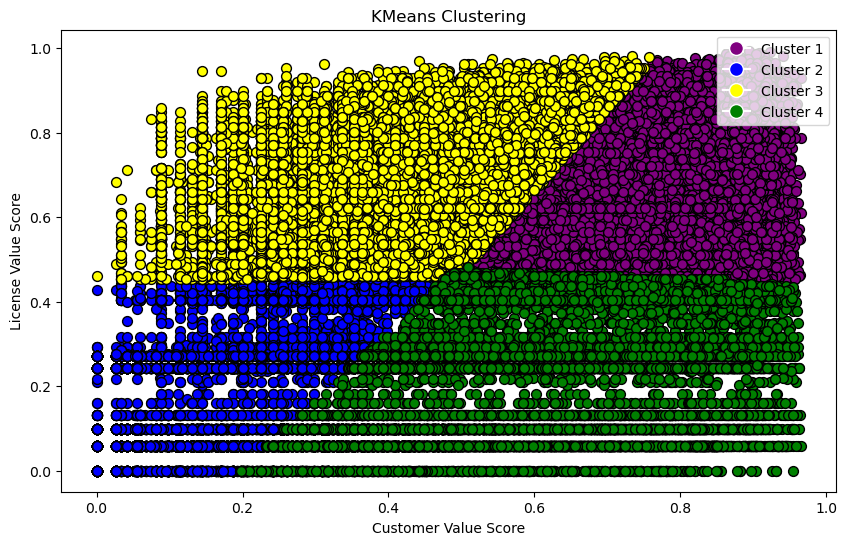

In [25]:
# Define colors for each cluster
cluster_colors = ['purple', 'blue', 'yellow', 'green']

# Plot the clusters using the first two features
plt.figure(figsize=(10, 6))

# Scatter plot of the data points, colored by cluster label
for i in range(kmeans.n_clusters):
    plt.scatter(score_features[:, -2][cluster_labels == i], score_features[:, -1][cluster_labels == i], color=cluster_colors[i], 
                label=f'Cluster {i+1}', marker='o', edgecolor='k', s=50)

# Scatter plot of the data points
# plt.scatter(score_features[:, -2], score_features[:, -1], c=cluster_labels, cmap='viridis', marker='o', edgecolor='k', s=50)

# Scatter plot of the cluster centers
# plt.scatter(cluster_centers[:, -2], cluster_centers[:, -1], c='red', marker='x', s=200, linewidths=3, edgecolor='k', label='Cluster Centers')

# Create custom legend for clusters
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {i+1}', 
                          markerfacecolor=cluster_colors[i], markersize=10) for i in range(kmeans.n_clusters)]
# legend_elements.append(Line2D([0], [0], marker='x', color='w', label='Cluster Centers', 
#                               markerfacecolor='red', markersize=10, linestyle='None', markeredgewidth=2))

# Add titles, labels and legend
plt.legend(handles=legend_elements, loc='upper right')
plt.title('KMeans Clustering')
plt.xlabel('Customer Value Score')
plt.ylabel('License Value Score')

# Show plot
plt.show()